## Validierung von DAG
**Zielsetzung:**
Dieses Notebook prüft, ob idendifizierte Zusammenhäng zwischen Variablen empirisch gestützt werden können.
Die verwendeten Teilmodelle basieren auf dem in Kapitel 4.4 entwickelten DAG. Die hier entwickelten Graphen zeigt alle Knoten, die auf Basis des validierten Datensatzes empirisch zugänglich waren.
Mittels DoWhy wird überprüft, ob ein identifizierbarer Backdoor-Pfad zwischen Treatment und Outcome vorliegt.
Die Schätzung erfolgt mithilfe linearer Regression. Der Effektwert wird im Anschluss interpretiert. 
Zum abschluss wird die Aussagekraft des geschätzten Effekt für beide Modelle mittels verschiedenen Refutern überprüfung.

### Aufbau des Notebooks
- **1) Modellstrukturierung** 

- **2) Identifikation**

- **3) Schätzung**

- **4) Robustheitsprüfung**

- **5) Zusammenfassung**



In [3]:
from dowhy import CausalModel
import pandas as pd
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Daten einlesen
# Datenquelle: konsolidierter Validierungsdatensatz aus Abschnitt 4.5.1
path_validation = r"..\syntheticData\RealDataMerged\mergedManupulated.xlsx"
data_input = pd.read_excel(path_validation)
display(data_input.head(5))

,FANummer,Menge,OperationNo,DurchlaufszeitIst(t),Rüst-Bearbeitungszeit(h),Rüstzeit(h),Bearbeitungszeit(h),DurchlaufszeitSoll(t),Soll/Ist Durchlaufszeit(t),Abweichung (Tage),Termintreue
0,FA1112305,21,20,34.00,1.93,1.62,0.32,9,-25.00,5,1
1,FA1114090,300,21,33.17,0.87,0.52,0.35,13,-20.17,1,1
2,FA1114511,36,22,25.04,27.75,0.30,27.45,13,-12.04,0,0
3,FA1114659,50,20,22.32,0.97,0.35,0.62,25,2.68,0,0
4,FA1114659,50,40,21.32,4.18,0.73,3.45,25,3.68,0,0


## 1) CausalModel Aufsetzen
Auf Basis der in Abschnitt 4.5.1 Argumentierten entscheidungslogik werden zwei Modelle aufsetzten 

    Fertigungsaufträge
    Arbeitgängen

diese dienen zur untersuchung auf den gegebenen zwei Niveaus.



#### 1.1) CausalModel für Fertigungsaufträge aufsetzen

In [5]:
#Kausalmodel mit Knoten und den jeweiligen Kanten definieren
G_Fertigungsauftrag = nx.DiGraph()
edges = [
    ("DurchlaufszeitSoll(t)", "Abweichung (Tage)"),
    ("Abweichung (Tage)", "Termintreue")
]
G_Fertigungsauftrag.add_edges_from(edges)

Sicherstellen das Alle Knoten im definierten Graphen `G_Fertigungsauftrag` als Variabel im Datensatzt und Welche Variablen aus dem Datenset nicht verwendet wurden. 

In [6]:
# Alle Knoten im Graphen
all_graph_variables = set(G_Fertigungsauftrag.nodes)

# Alle Spalten im DataFrame
all_data_variables = set(data_input.columns)

#Fehlende Werte fidnen
missing_variables_dataframe = all_graph_variables - all_data_variables
missing_variables_graph = all_data_variables - all_graph_variables
print("Fehlende Variablen im Dataframe:", missing_variables_dataframe)
print("Fehlende Variablen im Graph:", missing_variables_graph)

Fehlende Variablen im Dataframe: set()
Fehlende Variablen im Graph: {'OperationNo', 'DurchlaufszeitIst(t)', 'Soll/Ist Durchlaufszeit(t)', 'Bearbeitungszeit(h)', 'Rüst-Bearbeitungszeit(h)', 'Rüstzeit(h)', 'FANummer', 'Menge'}


In [7]:
#Model auf Basis von Graphen und zu Indendifizierendendem Pfad aufsetzten
model_Fertigungsauftrag = CausalModel(
    data=data_input,
    treatment="DurchlaufszeitSoll(t)",
    outcome="Termintreue",
    graph=G_Fertigungsauftrag
)

#### 1.2) CausalModel für Arbeitsgang aufsetzen (vergleichbar zu Prozess aus 2.1)

In [8]:
# 2.2) CausalModel aufsetzen
G_Arbeitgang = nx.DiGraph()
edges = [
    ("Rüstzeit(h)", "Rüst-Bearbeitungszeit(h)"),
    ("Bearbeitungszeit(h)", "Rüst-Bearbeitungszeit(h)"),
    ("Rüst-Bearbeitungszeit(h)", "DurchlaufszeitIst(t)")
]
G_Arbeitgang.add_edges_from(edges)

# Für Arbeitsgngang Graphen Sicherstellen das alle Knoten im definierten Graphen als Variabel im Datensatzt sind
all_graph_variables = set(G_Arbeitgang.nodes)
all_data_variables = set(data_input.columns)

missing_variables_dataframe = all_graph_variables - all_data_variables
missing_variables_graph = all_data_variables - all_graph_variables
print("Fehlende Variablen im Dataframe:", missing_variables_dataframe)
print("Fehlende Variablen im Graph:", missing_variables_graph)


model_Arbeitsgang = CausalModel(
    data=data_input,
    treatment="Rüstzeit(h)",
    outcome="DurchlaufszeitIst(t)",
    graph=G_Arbeitgang
)

Fehlende Variablen im Dataframe: set()
Fehlende Variablen im Graph: {'Termintreue', 'DurchlaufszeitSoll(t)', 'OperationNo', 'Soll/Ist Durchlaufszeit(t)', 'Menge', 'FANummer', 'Abweichung (Tage)'}


### kurze Visuelle kontrolle der Beiden Modelle mit view_Model()

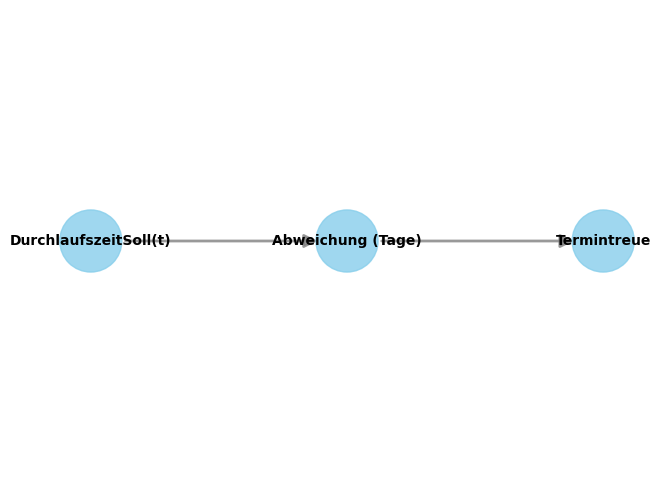

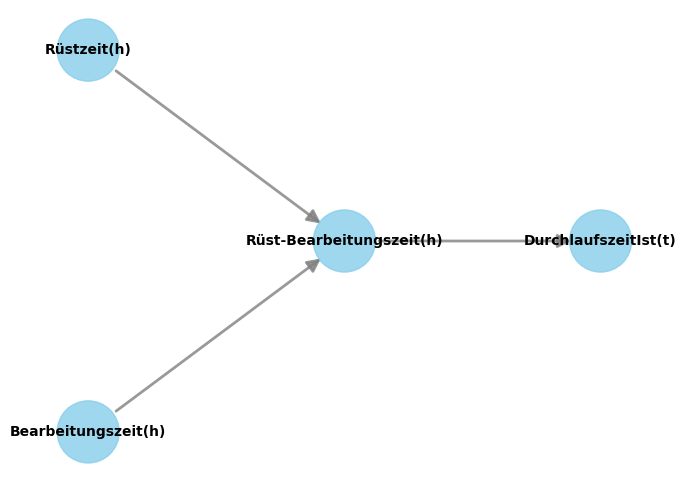

In [9]:
model_Fertigungsauftrag.view_model(file_name="GraphModelFertigungsauftrag")
model_Arbeitsgang.view_model(file_name="GraphModelArbeitsgang")

### 2 Identifikation des kausalen Effekts
Im ersten Schritt der Validierung wird geprüft, ob der kausale Effekt der Variable im vorgegebenen Modell identifizierbar sind.

`DurchlaufszeitSoll(t)` auf `Termintreue`

`Rüstzeit(h)` auf `DurchlaufszeitIst(t)`

Dabei generiert DoWhy verschiedene **Estimands**, also rechnerisch ausdrückbare Formen kausaler Effekte unter bestimmten Annahmen.

In [ ]:
# Identifizieren von DurchlaufszeitSoll(t) auf Termintreue
estimand = model_Fertigungsauftrag.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                            
────────────────────────(E[Termintreue])
d[DurchlaufszeitSoll(t)]                
Estimand assumption 1, Unconfoundedness: If U→{DurchlaufszeitSoll(t)} and U→Termintreue then P(Termintreue|DurchlaufszeitSoll(t),,U) = P(Termintreue|DurchlaufszeitSoll(t),)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡         d                                   d                               ↪
E⎢────────────────────(Termintreue)⋅────────────────────────([Abweichung (Tage ↪
 ⎣d[Abweichung (Tage)]              d[DurchlaufszeitSoll(t)]                   ↪

↪    ⎤
↪ )])⎥
↪    ⎦
Estimand assumption 1, Full-mediation: Abweichung (Tage) intercepts (blocks) all directed paths from DurchlaufszeitSoll(t) to T,e,r,m,i,n,t,r,e,u,e.
Estimand assumption 2, First-stage-unconfoundedness: I

### Identifikation: Modell Fertigungsauftrag

Für das Ziel, den kausalen Effekt der geplanten Durchlaufzeit `DurchlaufszeitSoll(t)` auf die Termintreue zu untersuchen, wurden durch DoWhy mehrere theoretisch mögliche Estimands geprüft.

Das Framework identifizierte erfolgreich einen **backdoor-Estimand**, welcher es unter der Annahme der Unconfoundedness erlaubt, den durchschnittlichen kausalen Effekt direkt aus beobachtbaren Daten zu schätzen. Das bedeutet, dass alle potenziellen Störgrössen entweder gemessen oder durch den DAG blockiert sind.

Zusätzlich wurde ein **frontdoor-Estimand** erkannt, der auf dem Pfad über `Abweichung (Tage)` basiert. Dieser Ansatz wäre theoretisch nützlich, falls unbeobachtete Confounder vorliegen. Die dafür nötigen Annahmen (vollständige Mediation, keine Confounder zwischen `DurchlaufszeitSoll(t)` und `Abweichung (Tage)` sowie zwischen `Abweichung (Tage)` und `Termintreue`) sind jedoch in der Praxis schwer zu garantieren.

Da kein geeignetes Instrument (IV) im Modell enthalten ist, entfällt eine Identifikation über IV.

→ Für die empirische Umsetzung wird der backdoor-Ansatz verwendet.

In [ ]:
# Identifizieren Rüstzeit(h) auf DurchlaufszeitIst(t)
estimand = model_Arbeitsgang.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                
──────────────(E[DurchlaufszeitIst(t)])
d[Rüstzeit(h)]                         
Estimand assumption 1, Unconfoundedness: If U→{Rüstzeit(h)} and U→DurchlaufszeitIst(t) then P(DurchlaufszeitIst(t)|Rüstzeit(h),,U) = P(DurchlaufszeitIst(t)|Rüstzeit(h),)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡             d                                          d                    ↪
E⎢───────────────────────────(DurchlaufszeitIst(t))⋅──────────────([Rüst-Bearb ↪
 ⎣d[Rüst-Bearbeitungszeit(h)]                       d[Rüstzeit(h)]             ↪

↪                 ⎤
↪ eitungszeit(h)])⎥
↪                 ⎦
Estimand assumption 1, Full-mediation: Rüst-Bearbeitungszeit(h) intercepts (blocks) all directed paths from Rüstzeit(h) to D,u,r,c,h,l,a,u,f,s,z,e,i,t,I,s,t,(,t,).
Estima

### Identifikation: Modell Arbeitsgang

Im zweiten Modell wird der kausale Einfluss der `Rüstzeit(h)` auf die tatsächliche Durchlaufzeit eines Arbeitsgangs `DurchlaufszeitIst(t)` untersucht. Auch hier wurde ein **backdoor-Estimand** identifiziert, welcher die Schätzung des durchschnittlichen kausalen Effekts unter der Annahme der Unconfoundedness erlaubt.

Zusätzlich wurde ein **frontdoor-Estimand** über die Variable `Rüst-Bearbeitungszeit(h)` erkannt. Dieser Pfad wäre dann nützlich, wenn unbeobachtete Confounder bestehen, die jedoch durch vollständige Mediation und strenge Unabhängigkeitsannahmen kontrollierbar wären. Diese sind in der gegebenen Datengrundlage nicht direkt verifizierbar, weshalb der frontdoor-Weg nur theoretisch berücksichtigt wird.

Auch hier konnte kein geeignetes Instrument (IV) im Modell erkannt werden.

→ Die Schätzung erfolgt folglich ebenfalls über den identifizierten backdoor-Ansatz.


In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

In [109]:
# Schätzen für Fertigungsaufträge DurchlaufszeitSoll(t) auf Termintreue
estimate = model_Fertigungsauftrag.estimate_effect(
    estimand,
    method_name="backdoor.linear_regression"
)
print("Estimated effect:", estimate.value)

Estimated effect: 1.4222740084205214


### Schätzung: Modell Fertigungsauftrag
Eine Erhöhung der geplanten Soll-Durchlaufzeit um eine Einheit (z.B. 1 Tag) ist mit einem durchschnittlichen Anstieg des Zielwerts `Termintreue` um etwa **1.42** Einheiten assoziiert. Da `Termintreue` als binäre Variable kodiert ist, übersteigt dieser Effekt formal die zulässige Skalenbreite **[0,1]** und darf nicht als absolute Wahrscheinlichkeitsveränderung interpretiert werden. Vielmehr ist der Wert als Richtungsindikator innerhalb eines approximativen linearen Modells zu verstehen, das kausale Zusammenhänge unter realweltlich begrenzten Datenbedingungen abschätzt.

Alternative Ansätze wie eine generalisierte lineare Regression (z.B. Logit-Modell) oder EconML-Bibliothek Alternativen wurden im Verlauf geprüft, konnten jedoch aufgrund technischer Inkompatibilität oder unzureichender Klassenverteilung im Datensatz nicht zuverlässig umgesetzt werden. Die gewählte lineare Regression stellt daher eine pragmatische Schätzstrategie dar, die im Rahmen des verfügbaren Frameworks eine interpretierbare, wenn auch begrenzt generalisierbare, Näherung kausaler Effekte erlaubt.



In [106]:
# Schätzen für Arbeitsgänge Rüstzeit(h) auf DurchlaufszeitIst(t)
estimate = model_Arbeitsgang.estimate_effect(
    estimand,
    method_name="backdoor.linear_regression"
)

# Interpretation:
# Ein negativer Effektwert bedeutet, dass eine längere Soll-Durchlaufzeit tendenziell mit schlechterer Termintreue assoziiert ist.
print("Estimated effect:", estimate.value)

Estimated effect: 0.9760294229369


### Schätzung: Modell Arbeitsgang

Der geschätzte kausale Effektwert für den Zusammenhang zwischen `Rüstzeit(h)` und `DurchlaufszeitIst(t)` beträgt **0.976**. Dies bedeutet, dass eine zusätzliche Stunde Rüstzeit im Mittel zu einer fast gleich grossen Verlängerung der tatsächlichen Durchlaufzeit eines Arbeitsgangs führt.

Die Stärke und Richtung des Effekts decken sich mit der fachlichen Erwartung aus dem Domänenwissen und stützen die Annahme, dass Rüstzeiten einen direkten und relevanten Einfluss auf die Effizienz einzelner Fertigungsschritte haben. Der nahezu lineare Zusammenhang legt nahe, dass potenzielle Reduktionen der Rüstzeit direkt zur Beschleunigung von Arbeitsprozessen beitragen könnten.

Da sowohl Treatment als auch Outcome metrisch skaliert sind, ist der Einsatz eines linearen Regressionsmodells in diesem Fall methodisch angemessen.

### 4 Robustheitsprüfung mittels Refutation

Zur Bewertung der Stabilität und Aussagekraft des geschätzten kausalen Effekts wurde eine Refutation-Analyse durchgeführt. Dabei prüft DoWhy mit verschiedenen Verfahren, ob der geschätzte Effekt auch unter gezielten Störungen oder Alternativannahmen bestehen bleibt. In dieser Analyse wurden drei unterschiedliche Refuter eingesetzt:

- **Placebo-Treatment-Refuter:** Prüft ob ein Effekt auch dann gefunden wird, wenn eine zufällige (irrelevante) Variable als Treatment eingesetzt wird.
- **Random-Common-Cause-Refuter:** Prüft die Sensitivität gegenüber unbeobachteten Confoundern durch künstliches hinzuzufügen einer potenzielle Störvariable.
- **Data-Subset-Refuter:** Prüft, ob der Effekt auch in zufällig gezogenen Teilmengen des Datensatzes stabil bleibt.

**Hinweis:** Die in den jeweiligen Markdowns referenzierten Effektwerte können sich bei wiederholter Ausführung des Notebooks oder durch minimale Datenänderungen leicht unterscheiden. Diese Abweichungen sind methodisch unkritisch, solange sich die Richtung und Relationen der Effekte nicht substantiell verändern.

In [73]:
# Refuter 1:    Placebo-Test
refuteF1 = model_Fertigungsauftrag.refute_estimate(
    estimand, estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)
print("Fertigungsauftrag", refuteF1)

refuteA1 = model_Arbeitsgang.refute_estimate(
    estimand, estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)
print("Arbeitsgang", refuteA1)

Fertigungsauftrag Refute: Use a Placebo Treatment
Estimated effect:0.9760294229369
New effect:0.03609887476330594
p value:0.78

Arbeitsgang Refute: Use a Placebo Treatment
Estimated effect:0.9760294229369
New effect:0.04740665294373811
p value:0.6599999999999999



### Robustheitsprüfung: Placebo-Test (Refuter)

Im Modell Fertigungsauftrag (`DurchlaufszeitSoll(t)` → `Termintreue`) reduzierte sich der Effektwert von 0.976 auf 0.036. Der zugehörige p-Wert von 0.78 gibt an, wie wahrscheinlich ein solcher Unterschied unter der Annahme ist, dass kein kausaler Zusammenhang besteht. Da der p-Wert deutlich über dem typischen Signifikanzniveau von 0.05 liegt, kann die Nullhypothese (kein Effekt) im Placebo-Fall nicht verworfen werden  was die Plausibilität des ursprünglichen Effekts stützt.

Im Modell Arbeitsgang (`Rüstzeit(h)` → `DurchlaufszeitIst(t)`) sank der Effekt unter Placebo auf 0.047 bei einem p-Wert von 0.66. Auch hier spricht die hohe p-Wahrscheinlichkeit gegen einen zufallsbedingten Scheinzusammenhang. Beide Tests deuten somit auf eine **robuste kausale Struktur** im ursprünglichen Modell hin.


In [74]:
# Refuter 2:    Random common cause 
refuteF2 = model_Fertigungsauftrag.refute_estimate(
    estimand, estimate,
    method_name="random_common_cause"
)
print("Fertigungsauftrag", refuteF2)

refuteA2 = model_Arbeitsgang.refute_estimate(
    estimand, estimate,
    method_name="random_common_cause"
)
print("Arbeitsgang", refuteA2)

Fertigungsauftrag Refute: Add a random common cause
Estimated effect:0.9760294229369
New effect:0.9762119402395534
p value:0.8999999999999999

Arbeitsgang Refute: Add a random common cause
Estimated effect:0.9760294229369
New effect:0.9755106495754
p value:0.78



### Robustheitsprüfung: Zufälliger Confounder (Random Common Cause)

Im Modell Fertigungsauftrag (`DurchlaufszeitSoll(t)` → `Termintreue`) blieb der geschätzte Effekt praktisch unverändert (von 0.976 auf 0.9762), mit einem p-Wert von 0.90. Dies spricht gegen eine strukturelle Instabilität des Modells gegenüber unbeobachteten Einflussgrössen.

Auch im Modell Arbeitsgang (`Rüstzeit(h)` → `DurchlaufszeitIst(t)`) ergab sich nur eine minimale Abweichung (von 0.976 auf 0.9755, p = 0.78). Beide Ergebnisse stützen die Aussage, dass die kausalen Schätzungen robust gegenüber zufälligen, modellfremden Störungen sind.


In [75]:
# Refuter 3: Data subset refuter 
refuteF3 = model_Fertigungsauftrag.refute_estimate(
    estimand, estimate,
    method_name="data_subset_refuter"
)
print("Fertigungsauftrag", refuteF3)

refuteA3 = model_Arbeitsgang.refute_estimate(
    estimand, estimate,
    method_name="data_subset_refuter"
)
print(refuteA3)

Fertigungsauftrag Refute: Use a subset of data
Estimated effect:0.9760294229369
New effect:0.994373137336322
p value:1.0

Refute: Use a subset of data
Estimated effect:0.9760294229369
New effect:0.992805928744778
p value:0.98



### Robustheitsprüfung: Teildatenanalyse (Data Subset Refuter)

Im Modell Fertigungsauftrag (`DurchlaufszeitSoll(t)` → `Termintreue`) blieb der Effekt mit 0.994 nahezu unverändert im Vergleich zum Ursprungswert von 0.976. Der p-Wert von 1.0 bestätigt die Stabilität.

Auch im Modell Arbeitsgang (`Rüstzeit(h)` → `DurchlaufszeitIst(t)`) ergab sich eine minimale Abweichung (0.993 vs. 0.976, p = 0.98). Beide Modelle zeigen sich somit robust gegenüber zufälliger Teilstichprobenbildung.


### 5) Zusammenfassung: Kausale Analyse und Modellvalidierung

In diesem Notebook wurde ein konzeptionell und empirisch fundiertes kausales Analyseverfahren umgesetzt, das auf einem zuvor entwickelten Strukturmodell (DAG) basiert. Ziel war es, zentrale Hypothesen zur Wirkung operativer Prozessfaktoren auf die Termintreue und Durchlaufzeit in einem realen Produktionskontext zu überprüfen.

Ausgehend von zwei Teilmodellen, einem auf Fertigungsauftragsebene (`DurchlaufszeitSoll(t)` auf `Termintreue`) und einem auf Arbeitsgangebene (`Rüstzeit(h)` auf `DurchlaufszeitIst(t)`), wurden mithilfe des DoWhy-Frameworks kausale Effekte identifiziert, geschätzt und auf ihre Robustheit hin geprüft. Die Schätzungen basierten auf einem validierten Datensatz, der unter Berücksichtigung von Datenverfügbarkeit, Prozesslogik und Modellstruktur manuell aus Teilsystemen zusammengestellt wurde.

Die Schätzung des kausalen Effekts erfolgte über lineare Regressionsmethoden, da alternative Verfahren wie logistische Regression aufgrund technischer Einschränkungen oder begrenzter Datenlage nicht zuverlässig integriert werden konnten. Die Effektwerte waren interpretierbar und deckten sich in ihrer Richtung teilweise mit domänenspezifischen Erwartungen oder gaben Anlass zu reflektierten Gegenhypothesen.

Die anschliessende Refutation-Analyse umfasste drei Testverfahren (Placebo-Treatment, Random Common Cause, Data Subset), welche zeigten, dass die beobachteten Effekte gegenüber zufälligen Störungen, hypothetischen Confoundern und Teilmengen der Daten stabil blieben. Die hohen p-Werte und geringen Effektabweichungen belegen die methodische Robustheit der Modelle.

Insgesamt liefert die Analyse eine nachvollziehbare und transparente Umsetzung eines kausalen Denkmodells mit DoWhy, das sowohl konzeptionell-theoretische als auch datenpraktische Herausforderungen im Kontext industrieller Entscheidungsprozesse berücksichtigt.